In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import xgboost as xgb

from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [2]:
# Reading the csv file
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Checking the feature names
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

**Observation**: Column names are consistent. [lowercase + underscore_seperated]

In [4]:
mask = (df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')
df_main = df[mask]

In [5]:
df_main = df_main.reset_index(drop=True)
df_main.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


### Preparing Dataset

#### Missing Values

In [6]:
# Checking the missing values
df_main.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
# Filling missing values with zeor
df_main = df_main.fillna(0)
df_main.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

#### Validation Framework and log transform to `median_house_value`

In [8]:
# Train/Test Split
df_train_full, df_test = train_test_split(df_main, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [9]:
# Resetting the index
df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
# Log transformation to the target variable
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [11]:
# Deleting target variable from dataframe
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

#### DictVectorizer

In [12]:
# Defining DicVectorizer
dv = DictVectorizer(sparse=False)

### Question: 1

In [13]:
# Training DictVectorizer
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
X_train

array([[  68.  ,   13.  ,   37.93, ...,  196.  ,   76.  ,  493.  ],
       [ 268.  ,   10.  ,   34.  , ...,  705.  ,  339.  , 1526.  ],
       [ 122.  ,   46.  ,   38.85, ...,  410.  ,  131.  ,  645.  ],
       ...,
       [ 551.  ,   26.  ,   34.01, ..., 1720.  ,  598.  , 3042.  ],
       [ 239.  ,   35.  ,   34.03, ..., 1015.  ,  249.  , 1375.  ],
       [ 245.  ,   25.  ,   36.8 , ..., 1050.  ,  255.  , 1270.  ]])

In [14]:
# Deining and Training DecisionTreeRegressor 
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
dt

DecisionTreeRegressor(max_depth=1)

In [15]:
# Find the feature index used for the root node
feature_idx = dt.tree_.feature[0]
print(dv.get_feature_names_out()[feature_idx])

ocean_proximity=<1H OCEAN


In [16]:
# Priniting Tree in Text Format
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



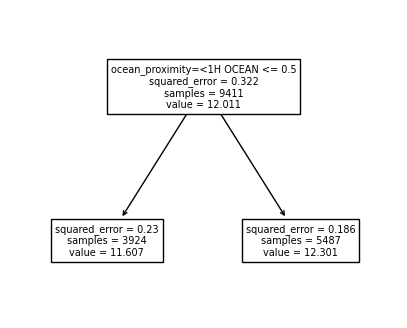

In [17]:
# Plotting Tree Graph
plt.figure(figsize=(5, 4))
plot_tree(dt, feature_names=dv.feature_names_)
plt.show()

**Answer:** `ocean_proximity` used to split the data.

### Question: 2

In [18]:
# Defining model and training
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [19]:
# Validation
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = rf.predict(X_val)

In [20]:
# Defining RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [21]:
print(rmse(y_val, y_pred).round(3))

0.245


**Answer:** RMSE of this `RandomForesetRegressor` model on validation is `0.245`.

### Question: 3

In [22]:
# Finding the best value of n_estimators
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = rmse(y_val, y_pred).round(3)
    scores.append((n, score))

In [23]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

,n_estimators,rmse
0,10,0.245
1,20,0.238
2,30,0.236
3,40,0.235
4,50,0.235
5,60,0.234
6,70,0.234
7,80,0.234
8,90,0.234
9,100,0.234


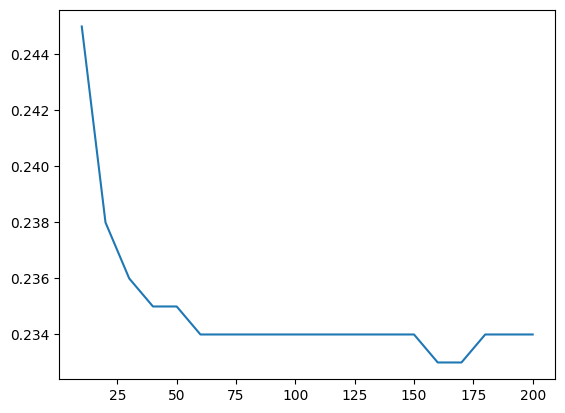

In [24]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

**Answer:** Value of `n_estimators` is `160`.

### Question: 4

In [25]:
# Finding the value of score for different combination of n_estimators and max_depth
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred).round(3)

        scores.append((d, n, score))

In [26]:
# Converting into DataFrame
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [27]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.251
1,10,20,0.247
2,10,30,0.246
3,10,40,0.245
4,10,50,0.246
...,...,...,...
75,25,160,0.233
76,25,170,0.233
77,25,180,0.234
78,25,190,0.234


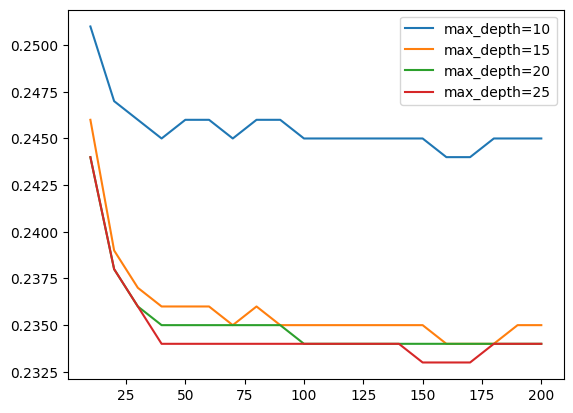

In [28]:
# Plotting the graph
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)

plt.legend()
plt.show()

**Answer:**  The best `max_depth`, using the mean RMSE is `20`.

### Question: 5

In [29]:
# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)

# Train the model
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Get the index of the most important feature
max_index = feature_importances.argmax()

# Print the most important feature and its importance
print(f"{dv.feature_names_[max_index]}: {feature_importances[max_index]}")

median_income: 0.33548579019301683


**Answer:** Most important feature is `median_income`.

### Question: 6

In [30]:
# Getting and sanitizing feature names
features = dv.get_feature_names_out()
features = [f.replace("=", "_").replace("[", "_").replace("]", "_").replace("<", "_") for f in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

**First model with `eta=0.3`**

In [31]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
rmse(y_val, y_pred).round(3)

0.229

**Second model with `eta=0.1`**

In [32]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
rmse(y_val, y_pred).round(3)

0.232

**Answer:** `eta=0.3` leads to best rmse score.